In [40]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import set_config
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import r2_score, mean_absolute_error
from matplotlib import pyplot as plt
import pickle 

In [41]:
# Import de la jointure contenant les données des tables title_basics, name.basics et title.ratings
df = pd.read_csv('datasets/basics_knownForTitles_ratings.csv', index_col=0)
(df.tconst.value_counts() == 1).all()
df = df.query('numVotes >= 375')
df = df.dropna()
df = df.query('isAdult == 0')
df = df.drop(columns=['tconst', 'primaryTitle','isAdult'], axis=1)
df['nconst'] = df['nconst'].str.replace(',', ' ')
df['genres'] = df['genres'].str.replace(',', ' ')
df

,decade,runtimeMinutes,genres,nconst,averageRating,numVotes
7,192.0,106.0,Drama Romance,nm0909066 nm0948806 nm0497372 nm0245078 nm0401...,6.0,496
9,192.0,127.0,Drama War,nm0412014 nm0409109 nm0348705 nm0214113 nm2227...,7.0,2188
12,193.0,79.0,Drama Romance,nm0719686 nm1393139 nm1393547 nm1394878 nm1394...,6.1,1062
13,193.0,83.0,Biography Drama Music,nm0250439 nm0923146 nm0440169,6.3,444
17,193.0,85.0,Drama Romance,nm0801209,6.7,523
...,...,...,...,...,...,...
286796,200.0,105.0,Comedy,nm1910698 nm1901451 nm2056354 nm2103617 nm1924...,5.2,8567
286798,201.0,98.0,Comedy Drama Horror,nm0816003 nm1335461 nm1324246 nm1997974 nm4147...,2.9,1819
286801,202.0,107.0,Drama Horror,nm11777181 nm3631020 nm13926845 nm9278354 nm10...,5.3,4044
286804,201.0,85.0,Comedy Crime Drama,nm11470103 nm2543454 nm6598458 nm6599739 nm094...,6.5,1433


In [42]:
# Numerical variables
column_num = ['decade', 'runtimeMinutes']
transfo_num = Pipeline(steps=[
    ('scaling', RobustScaler())
])

In [43]:
# Categorical variables
column_tex1 = 'genres'
column_tex2 = 'nconst'
transfo_tex = Pipeline(steps=[
    ('countvec', CountVectorizer()), 
    ('dr', TruncatedSVD())    
    ])

In [44]:
# Class ColumnTransformer : apply alls steps on the whole dataset
preparation = ColumnTransformer(
    transformers=[
        ('data_tex1', transfo_tex , column_tex1),
        ('data_tex2', transfo_tex , column_tex2),
        ('data_num', transfo_num , column_num)
    ])

In [45]:
# Declare the pipeline
pipe = Pipeline(steps=[('preparation', preparation),
                        ('model', HistGradientBoostingRegressor())])

In [46]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preparation', 'model', 'preparation__n_jobs', 'preparation__remainder', 'preparation__sparse_threshold', 'preparation__transformer_weights', 'preparation__transformers', 'preparation__verbose', 'preparation__verbose_feature_names_out', 'preparation__data_tex1', 'preparation__data_tex2', 'preparation__data_num', 'preparation__data_tex1__memory', 'preparation__data_tex1__steps', 'preparation__data_tex1__verbose', 'preparation__data_tex1__countvec', 'preparation__data_tex1__dr', 'preparation__data_tex1__countvec__analyzer', 'preparation__data_tex1__countvec__binary', 'preparation__data_tex1__countvec__decode_error', 'preparation__data_tex1__countvec__dtype', 'preparation__data_tex1__countvec__encoding', 'preparation__data_tex1__countvec__input', 'preparation__data_tex1__countvec__lowercase', 'preparation__data_tex1__countvec__max_df', 'preparation__data_tex1__countvec__max_features', 'preparation__data_tex1__countvec__min_df', 'preparation__data_t

In [47]:
# Declare model and parameter for Grid Search
parameters = {'model__learning_rate': [ 0.001, 0.05], 'model__max_iter' : range(160, 190, 10), 'model__max_leaf_nodes': range(100, 110, 10), 'model__max_depth': range(11, 12), 'model__min_samples_leaf' : range(40, 50, 10)}

In [48]:
# Declare the Grid Search method
grid = GridSearchCV(pipe, parameters, scoring=['r2', 'neg_mean_absolute_error'], refit='r2', cv = 3, n_jobs =-1, verbose = 1)

In [49]:
# Display diagram
set_config(display="diagram")
preparation

ColumnTransformer(transformers=[('data_tex1',
                                 Pipeline(steps=[('countvec',
                                                  CountVectorizer()),
                                                 ('dr', TruncatedSVD())]),
                                 'genres'),
                                ('data_tex2',
                                 Pipeline(steps=[('countvec',
                                                  CountVectorizer()),
                                                 ('dr', TruncatedSVD())]),
                                 'nconst'),
                                ('data_num',
                                 Pipeline(steps=[('scaling', RobustScaler())]),
                                 ['decade', 'runtimeMinutes'])])

In [50]:
# Fit the model
y = df['averageRating']
X = df.drop(columns='averageRating')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
model = grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [51]:
pickle_out = open("model.pkl", "wb")
pickle.dump(model, pickle_out)
pickle_out.close() 

In [52]:
# Evaluate cross validation performance 
print("CV score:", grid.best_score_)

CV score: 0.3547884749222536


In [53]:
# Find the best parameters 
print("CV parameters:", grid.best_params_)

CV parameters: {'model__learning_rate': 0.05, 'model__max_depth': 11, 'model__max_iter': 180, 'model__max_leaf_nodes': 100, 'model__min_samples_leaf': 40}


In [54]:
# Make predictions
y_pred = grid.predict(X_test)

In [55]:
# Evaluate model performance
print("R2 score", r2_score(y_test, y_pred))
print("MAE", mean_absolute_error(y_test, y_pred))

R2 score 0.3749683769103265
MAE 0.7354239462687218


Text(0.5, 1.0, 'Distribution Exponentielle de la MAE')

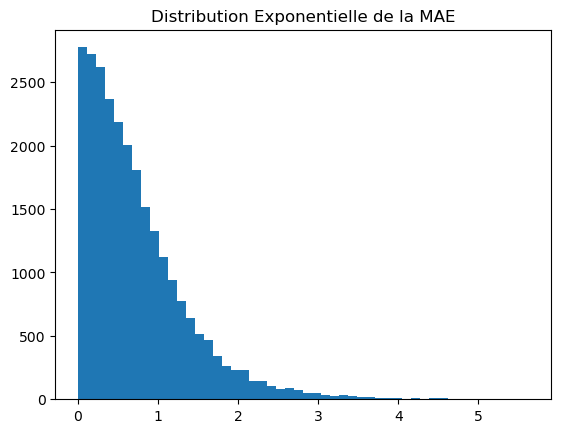

In [56]:
fig1, ax1 = plt.subplots()
err_hist = np.abs(y_test - y_pred)
plt.hist(err_hist, bins=50)
ax1.set_title('Distribution Exponentielle de la MAE')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8dc9d471c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8dc9d47700>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8db2efeeb0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8dc9d47c40>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8dc9d47ee0>],
 'means': []}

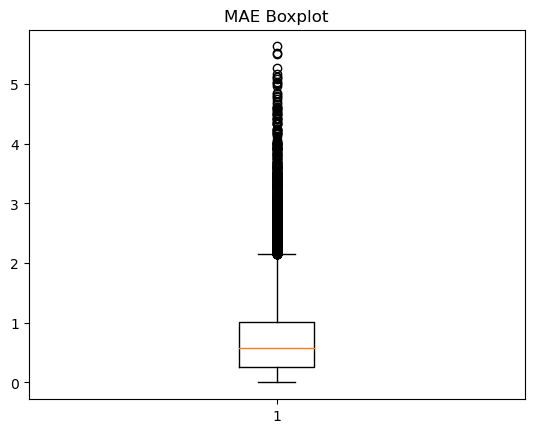

In [57]:
fig1, ax1 = plt.subplots()
ax1.set_title('MAE Boxplot')
ax1.boxplot(err_hist)